In [1]:
print('Initializing data engineering!')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json, requests, gzip

Initializing data engineering!


### Brazil data engineering

In [2]:
url = 'https://data.brasil.io/dataset/covid19/caso.csv.gz'
response = requests.get(url)
# response.content
with open('/home/rafael/tmp/caso.csv.gz', 'wb') as f:
    f.write(response.content)

In [3]:
with gzip.open('/home/rafael/tmp/caso.csv.gz') as f:
    df = pd.read_csv(f)

In [4]:
df.rename(columns={'confirmed': 'cases', 'estimated_population_2019':'population', 'order_for_place':'day'}, inplace= True)
df['date'] = df['date'].astype('datetime64[ns]')

df = df[(df['city']!='Importados/Indefinidos')]

#apenas cidades de SP e por estados
df = df[((df['state']=='SP') & (df['place_type']=='city')) | (df['place_type']=='state')  ]
# df = df[(df['place_type']=='state')  ]

df.population.fillna(0, inplace=True)
df.city_ibge_code.fillna(0, inplace=True)

df.population = df.population.astype('int')
df.city_ibge_code = df.city_ibge_code.astype('int')

df.drop(columns=['confirmed_per_100k_inhabitants'], inplace=True)
df.fillna('-', inplace=True)

df.sort_values(['state','city','date'], inplace = True)
df.reset_index(inplace = True, drop=True)


# df['week'] = df.date.dt.isocalendar().week 
df['year'] = df.date.dt.year
df['yearMonth'] = df.date.map(lambda x: x.strftime('%Y-%m'))
df['yearWeek'] = df.date.map(lambda x: x.strftime('%y-%V'))
df['diasMes'] = df.date.dt.days_in_month
# df['week'] = np.arange(len(df['yearWeek']))

df.tail()

,date,state,city,place_type,cases,deaths,day,is_last,population,estimated_population,city_ibge_code,death_rate,year,yearMonth,yearWeek,diasMes
194929,2021-02-28,TO,-,state,114467,1532,348,False,1572866,1590248.0,17,0.0134,2021,2021-02,21-08,28
194930,2021-03-01,TO,-,state,115341,1539,349,False,1572866,1590248.0,17,0.0133,2021,2021-03,21-09,31
194931,2021-03-02,TO,-,state,116038,1549,350,False,1572866,1590248.0,17,0.0133,2021,2021-03,21-09,31
194932,2021-03-03,TO,-,state,116912,1557,351,False,1572866,1590248.0,17,0.0133,2021,2021-03,21-09,31
194933,2021-03-04,TO,-,state,117728,1565,352,True,1572866,1590248.0,17,0.0133,2021,2021-03,21-09,31


In [5]:
ultimaData = df.date.max()
hoje = datetime.datetime.now()
offset = 0 if (ultimaData.date() == hoje.date()) else 1
df.loc[df['yearMonth']==str(ultimaData.year) + '-' + '{:02d}'.format(ultimaData.month), 'diasMes'] = ultimaData.day - offset
hoje.day - offset

5

#### Feature engineering - por semana

In [6]:
print('Iniciando feature engieering Brasil')
inicio = datetime.datetime.now()

states = df.state.unique()
# states = ['SP']
df.drop(df[df['cases'] == 0 ].index, axis=0, inplace= True)

df['perc_death'] = (df['deaths']/df['cases'] * 100).round(2)
df.rename(columns={'order_for_place': 'day'}, inplace= True)

for state in states:
    cities = df[df['state']==state].city.unique()
#     cities = ['Santa Gertrudes']
#     print(datetime.datetime.now().time(), state)
    for city in cities:
        indexes = (df['state']==state) & (df.city == city)
        # valores diários
        df.loc[indexes, 'case_day'] = df[indexes]['cases'].diff()    
        df.loc[indexes, 'death_day'] = df[indexes]['deaths'].diff()

        # Igualo o valor da primeira linha igual ao primeiro número do acumulado, pois se o acumulado começa em 1 o primeiro diff fica igual a 0
        df.loc[(indexes) & (df.day == 1), 'case_day']= df.loc[(indexes) & (df.day==1), 'cases']
        df.loc[(indexes) & (df.day == 1), 'death_day']= df.loc[(indexes) & (df.day==1), 'deaths']

#         % daily variations
#         df.loc[indexes, 'var_case_day'] = ((df[indexes]['case_day'].diff())) #/ df[indexes]['case_day'].shift()*100).replace([np.inf, -np.inf], 0).replace([np.nan], 0).round(2)
#         df.loc[indexes, 'var_death_day'] = ((df[indexes]['death_day'].diff())) #/ df[indexes]['death_day'].shift()*100).replace([np.inf, -np.inf], 0).replace([np.nan], 0).round(2)
#         df.loc[indexes, '%var_death_day'] = (((df[indexes]['death_day'] - df[indexes]['death_day'].shift()) / df[indexes]['death_day'].shift())*100).replace([np.inf, -np.inf], 0).replace([np.nan], 0).round(2)
            
        # Buscando a população do estado/cidade e calculado os indicador per milhar
        if not df[indexes].population.empty:
            thousand = df[indexes]['population'] / 1000
            cases_thousand = (df[indexes]['cases'] / thousand)
            deaths_thousand = (df[indexes]['deaths'] / thousand)
            case_day_thousand = (df[indexes]['case_day'] / thousand)
            death_day_thousand = (df[indexes]['death_day'] / thousand)
        else:
            cases_thousand = 0
            deaths_thousand = 0
            case_day_thousand = 0
            death_day_thousand = 0
            
        df.loc[indexes, 'cases_thousand'] = cases_thousand
        df.loc[indexes, 'deaths_thousand'] = deaths_thousand
        df.loc[indexes, 'case_day_thousand'] = case_day_thousand
        df.loc[indexes, 'death_day_thousand'] = death_day_thousand
        
#         df.loc[indexes, 'avg7_deaths'] = df[indexes]['death_day'].rolling(window=7).mean()
#         df.loc[indexes, 'avg7_death_day_thousand'] = df[indexes]['death_day_thousand'].rolling(window=7).mean()

#         df.loc[indexes, 'death_day_medio']= df[indexes]['death_day'].expanding().mean()


df.fillna(0, inplace=True)

df['case_day'] = df['case_day'].astype('int')
df['death_day'] = df['death_day'].astype('int')


df['cases_thousand'] = df['cases_thousand'].round(3)
df['deaths_thousand'] = df['deaths_thousand'].round(3)
df['case_day_thousand'] = df['case_day_thousand'].round(3)
df['death_day_thousand'] = df['death_day_thousand'].round(3)


df['cases'] = df['case_day']
df['deaths'] = df['death_day']


termino = datetime.datetime.now()
print('finalizado em ', termino-inicio)
df[indexes].tail()

Iniciando feature engieering Brasil
finalizado em  0:00:25.238578


,date,state,city,place_type,cases,deaths,day,is_last,population,estimated_population,...,yearMonth,yearWeek,diasMes,perc_death,case_day,death_day,cases_thousand,deaths_thousand,case_day_thousand,death_day_thousand
194929,2021-02-28,TO,-,state,543,6,348,False,1572866,1590248.0,...,2021-02,21-08,28,1.34,543,6,72.776,0.974,0.345,0.004
194930,2021-03-01,TO,-,state,874,7,349,False,1572866,1590248.0,...,2021-03,21-09,5,1.33,874,7,73.332,0.978,0.556,0.004
194931,2021-03-02,TO,-,state,697,10,350,False,1572866,1590248.0,...,2021-03,21-09,5,1.33,697,10,73.775,0.985,0.443,0.006
194932,2021-03-03,TO,-,state,874,8,351,False,1572866,1590248.0,...,2021-03,21-09,5,1.33,874,8,74.331,0.990,0.556,0.005
194933,2021-03-04,TO,-,state,816,8,352,True,1572866,1590248.0,...,2021-03,21-09,5,1.33,816,8,74.849,0.995,0.519,0.005


In [7]:
# df2 =  df.groupby(['state','city','yearMonth'], sort=True).agg({
# df2 =  df.groupby(['week'], sort=True).agg({

dados = df.copy()
# dados = df.loc[(df['state']=='AM') & (df ['place_type']=='state')]
# dados = df.loc[(df['city']=='São Paulo') & (df ['place_type']=='city')]
# dados = df.loc[(df['city']=='Lucélia') & (df ['place_type']=='city')]

df2 =  dados.groupby(['yearMonth'], sort=True).agg({
        'cases':'sum', 
        'deaths': 'sum',
        'case_day':'mean',
        'death_day': 'mean',
        'case_day_thousand':'mean',
        'death_day_thousand':'mean',
        'cases_thousand':'mean',
        'deaths_thousand':'mean',
        'diasMes':'mean',
})


df3 =  dados.groupby(['yearWeek'], sort=True).agg({
        'cases':'sum', 
        'deaths': 'sum',
        'case_day':'mean',
        'death_day': 'mean',
        'case_day_thousand':'mean',
        'death_day_thousand':'mean',
        'cases_thousand':'mean',
        'deaths_thousand':'mean',
        'diasMes':'mean',
})

df3.reset_index(drop=True, inplace=True) #só para ficar com uma lista de números incrementais
df3.head()

df2.tail()

,cases,deaths,case_day,death_day,case_day_thousand,death_day_thousand,cases_thousand,deaths_thousand,diasMes
yearMonth,,,,,,,,,
2020-11,929720,16080,57.118634,0.987897,0.097133,0.002291,22.618210,0.576382,30
2020-12,1559700,26426,79.824965,1.352475,0.150744,0.002713,25.808725,0.633891,31
2021-01,1842476,35891,91.283987,1.778191,0.247925,0.004290,31.491642,0.736578,31
2021-02,1613778,36988,85.789060,1.966296,0.244479,0.005128,38.949876,0.877353,28
2021-03,337774,8416,434.715573,10.831403,0.372654,0.010610,45.467973,1.005199,5


In [8]:
df2['deaths_mean']= df2.deaths.expanding().mean()
df2['death_thousand_mean']= df2.deaths_thousand.expanding().mean()
df2['death_day'] = df2['deaths']/df2['diasMes']
df2['death_day_mean']= df2.death_day.expanding().mean()

df2['perc_var_deaths'] = (((df2['death_day'] - df2['death_day'].shift()) / df2['death_day'].shift())*100).replace([np.inf, -np.inf], 0).replace([np.nan], 0).round(0)

# df2['death_day_thousand_mean']= df2.death_day_thousand.expanding().mean()

df3['deaths_mean']= df3.deaths.expanding().mean()
df3['death_thousand_mean']= df3.deaths_thousand.expanding().mean()
# df3['death_day_mean']= df3.death_day.expanding().mean()
df3['death_day_thousand_mean']= df3.death_day_thousand.expanding().mean()
df3['death_day_mean'] = df3['deaths']/7
df2.tail()

,cases,deaths,case_day,death_day,case_day_thousand,death_day_thousand,cases_thousand,deaths_thousand,diasMes,deaths_mean,death_thousand_mean,death_day_mean,perc_var_deaths
yearMonth,,,,,,,,,,,,,
2020-11,929720,16080,57.118634,536.000000,0.097133,0.002291,22.618210,0.576382,30,21536.300000,0.207679,704.356344,-16.0
2020-12,1559700,26426,79.824965,852.451613,0.150744,0.002713,25.808725,0.633891,31,21980.818182,0.246426,717.819550,59.0
2021-01,1842476,35891,91.283987,1157.774194,0.247925,0.004290,31.491642,0.736578,31,23140.000000,0.287272,754.482437,36.0
2021-02,1613778,36988,85.789060,1321.000000,0.244479,0.005128,38.949876,0.877353,28,24205.230769,0.332663,798.060711,14.0
2021-03,337774,8416,434.715573,1683.200000,0.372654,0.010610,45.467973,1.005199,5,23077.428571,0.380701,861.284946,27.0


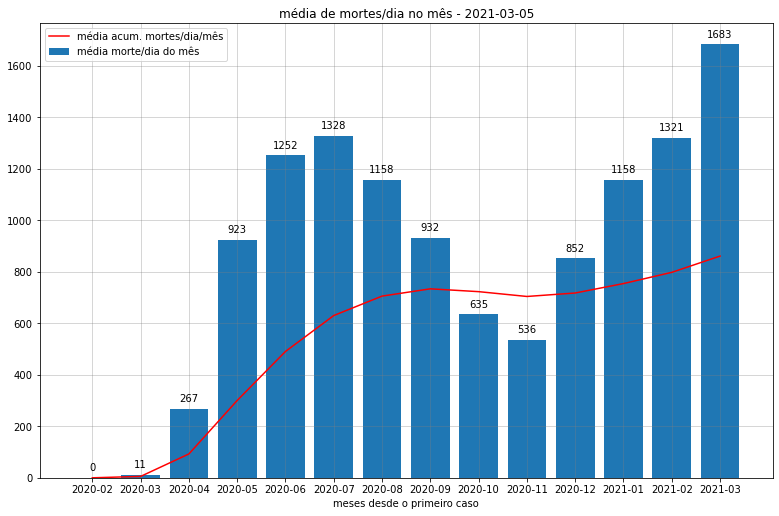

In [9]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig, ((ax2)) = plt.subplots(1,1, figsize=(12, 8))
fig.tight_layout(pad=5.0)

ax2.set_title("média de mortes/dia no mês - " + str(df.date.max().date()))
ax2.set_xlabel("meses desde o primeiro caso")
ax2.grid(color='gray', alpha = 0.4)

ax2.bar(df2.index, df2.death_day, label='média morte/dia do mês')
ax2.plot(df2.index, df2['death_day_mean'],  label='média acum. mortes/dia/mês', color='red')

for p in ax2.patches:
    ax2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
ax2.legend()
fig.savefig('../analysis/temp.png')

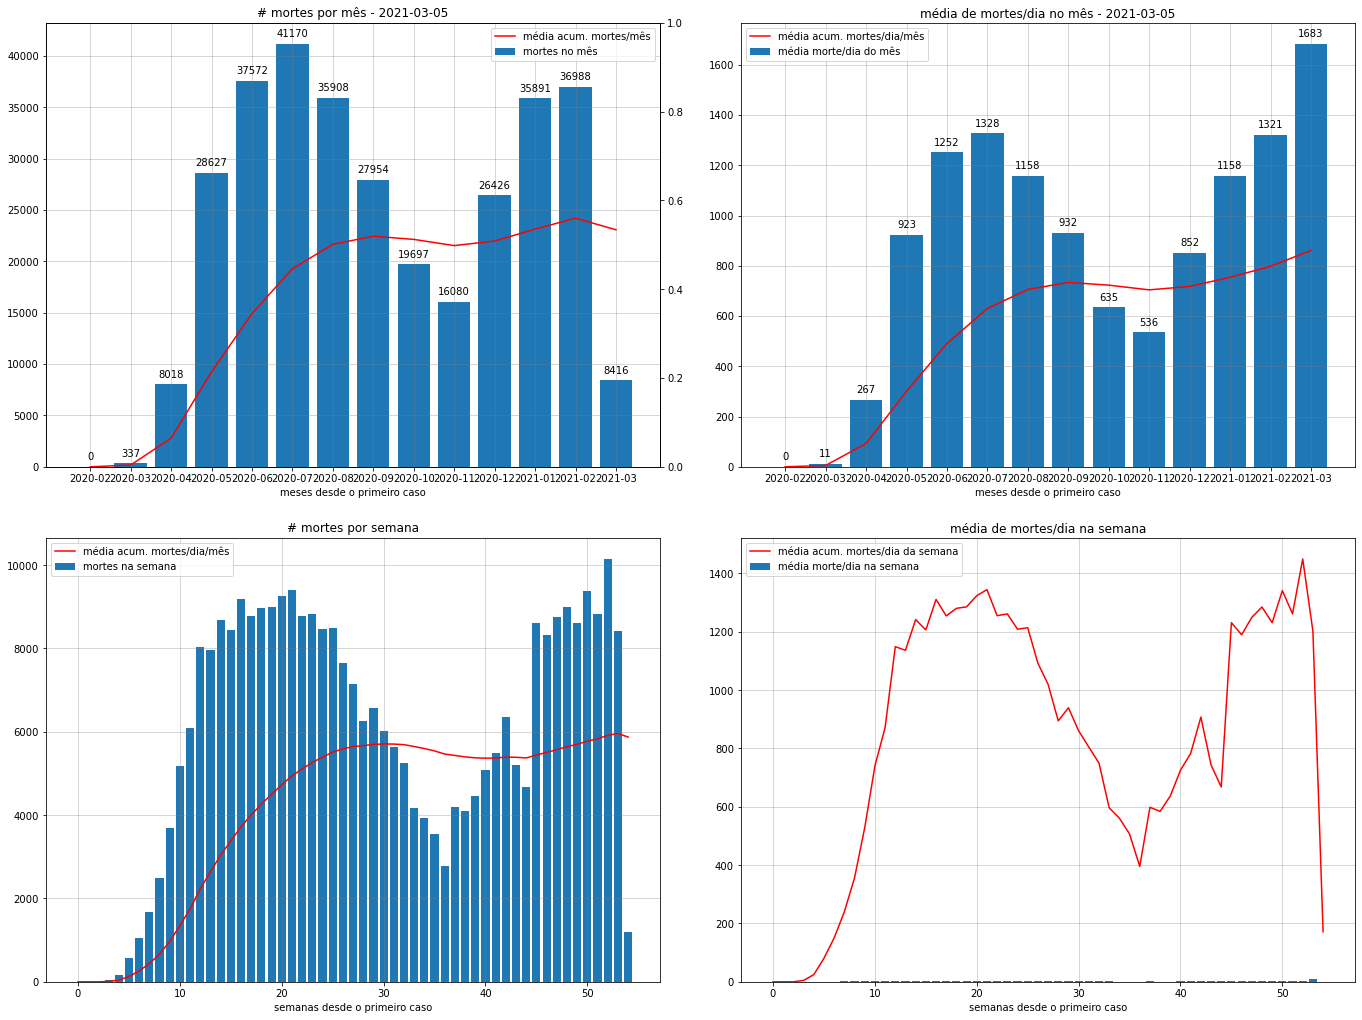

In [10]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("# mortes por mês - " + str(df.date.max().date()))
ax1.set_xlabel("meses desde o primeiro caso")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("média de mortes/dia no mês - " + str(df.date.max().date()))
ax2.set_xlabel("meses desde o primeiro caso")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("# mortes por semana")
ax3.set_xlabel("semanas desde o primeiro caso")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("média de mortes/dia na semana")
ax4.set_xlabel("semanas desde o primeiro caso")
ax4.grid(color='gray', alpha = 0.4)

# ax5.set_title("Cumulative recoveries")
# ax5.set_xlabel("days from the first case")
# ax5.grid(color='gray', alpha = 0.4)

# ax6.set_title("Recoveries - moving average (last 7 days)")
# ax6.set_xlabel("days from the first case")
# ax6.grid(color='gray', alpha = 0.4)


ax1.bar(df2.index, df2.deaths, label='mortes no mês')
ax1.plot(df2.index, df2['deaths_mean'],  label='média acum. mortes/mês', color='red')
# ax1.plot(df2.index, df2['deaths_mean'],  label='%', color='green', secondary_y=True, ax=ax)

ax1y = ax1.twinx()
# ax1y.set_ylabel('% var.', color='purple')  # we already handled the x-label with ax1
# ax1y.plot(df2.index, df2['perc_var_deaths'], color='purple')
# ax1y.tick_params(axis='y', labelcolor='purple')
for p in ax1.patches:
    ax1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    

ax2.bar(df2.index, df2.death_day, label='média morte/dia do mês')
ax2.plot(df2.index, df2['death_day_mean'],  label='média acum. mortes/dia/mês', color='red')

for p in ax2.patches:
    ax2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
ax3.bar(df3.index, df3.deaths, label='mortes na semana')
ax3.plot(df3.index, df3['deaths_mean'],  label='média acum. mortes/dia/mês', color='red')

ax4.bar(df3.index, df3.death_day, label='média morte/dia na semana')
ax4.plot(df3.index, df3['death_day_mean'],  label='média acum. mortes/dia da semana', color='red')


# for index, value in enumerate(df2.death_day):
# #     ax2.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
#     ax2.annotate(value, index, str(value))
    

# ax2.plot(dados.day, dados.avg7_cases, label = state)
# ax3.plot(dados.day, dados.deaths, label = state)
# ax4.plot(dados.day, dados.avg7_deaths, label = state)
#     ax5.plot(df[indexes].day, df[indexes].recoveries, label = state)
#     ax6.plot(df[indexes].day, df[indexes].avg7_recoveries, label = state)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax5.legend()
# ax6.legend()
# fig.savefig('../analysis/temp.png')